# DiaObject Anomaly Detection for Variable Stars in DP0.2

<img align="left" src = https://project.lsst.org/sites/default/files/Rubin-O-Logo_0.png width=250 style="padding: 10px"> 

<br>Contact author(s): Jeff Carlin, Ryan Lau <br>
Last verified to run: 2025-04-07 <br>
LSST Science Pipelines version: Weekly 2025_14 <br>
Container Size: medium <br>
Targeted learning level: Intermediate <br>

**Description:** Apply anomaly detection techniques to DIA Objects from the DP0.2 catalogs with the goal of finding variable stars.

**Skills:** Use Isolation Forest algorithm on the DP0.2 DiaObject Table. Plot results and inspect anomalies. Create phased lightcurves of candidate variable stars.

**LSST Data Products:** TAP tables dp02_dc2_catalogs.DiaObject, ForcedSourceOnDiaObject

**Packages:** lsst, scikit-learn, pandas, matplotlib, numpy, astropy, PIL


**Credit:**
Adaptation of DP0.2 notebook 17_DiaObject_Anomaly_Detection.ipynb.

**Get Support:**
Find DP0-related documentation and resources at <a href="https://dp0-2.lsst.io">dp0-2.lsst.io</a>. Questions are welcome as new topics in the <a href="https://community.lsst.org/c/support/dp0">Support - Data Preview 0 Category</a> of the Rubin Community Forum. Rubin staff will respond to all questions posted there. For more information, please consider reaching out to the Anomaloy Detection interest group of the <a href="https://issc.science.lsst.org/">LSST Informatics & Statistics Science Collaboration</a>.

## 1. Introduction

The DP0.2 dataset contains some simulated pulsating variable stars, including [RR Lyrae](https://ogle.astrouw.edu.pl/atlas/RR_Lyr.html) stars, which are old, low-mass, metal-poor horizontal branch stars within the instability strip. These stars pulsate -- and thus change their brightness -- over periods of about 0.2 to 1 day (i.e., several hours). In addition to the physics of their pulsation, these stars are useful because they exhibit a tight "period-luminosity relation", as originally demonstrated by Henrietta Swan Leavitt in ~1912. Below is her original diagram (from [this AAVSO page](https://www.aavso.org/vsots_rrlyr)) showing the magnitude vs. measured pulsation periods (x-axis) of pulsating variable stars in the SMC.

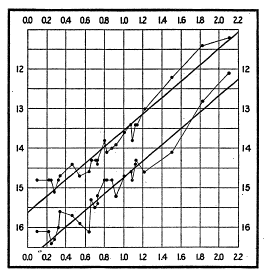

RR Lyrae are relatively easy to find because they can vary by almost a full magnitude over a few hours. Once we find them we can derive their distances because they follow the period-luminosity relation -- measure the period, know the intrinsic luminosity, and use this to derive the distance to the star!

This notebook adapts an anomaly detection technique derived for DP0.2 tutorial 17_DiaObject_Anomaly_Detection.ipynb on difference-image analysis (DIA) objects. It demonstrates how to perform the following:

1. apply the IsolationForest routine from [`scikit-learn`](https://scikit-learn.org/stable/);
2. identify candidate variable stars as anomalous DiaObjects from the DP0.2 catalogs;
3. extract and plot lightcurves of the anomalous targets.

For further introduction and motivation on investigating anomalies, please view the following link: <a href="https://www.lsst.org/science/transient-optical-sky/unimagined ">The Unimagined</a>

### 1.1. Package imports

Import general python packages, the IsolationForest algorithm from `scikit-learn`, and the Rubin TAP service utilities.

The [`matplotlib`](https://matplotlib.org/), [`numpy`](http://www.numpy.org/), and [`scikit-learn`](https://scikit-learn.org/stable/) libraries are widely used Python libraries for plotting, scientific computing, and conducting Machine-Learning data analysis. We will use these packages below, including the `lsst.rsp` package to access the TAP service and query the DP0 catalogs.

We also use the `lsst.rsp` package to access the TAP service and query the DP0 catalogs.

Finally, we import two Astropy packages, `LombScargleMultiband` and `units`, to use in estimating periods for variable star candidates.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest
from lsst.rsp import get_tap_service

from astropy.timeseries import LombScargleMultiband
import astropy.units as u

Define plotting parameters for consistent figures.

In [ ]:
plt.style.use('tableau-colorblind10')

plot_filter_labels = ['u', 'g', 'r', 'i', 'z', 'y']
plot_filter_colors = {'u': '#56b4e9', 'g': '#008060', 'r': '#ff4000',
                      'i': '#850000', 'z': '#6600cc', 'y': '#000000'}
plot_filter_symbols = {'u': 'o', 'g': '^', 'r': 'v',
                       'i': 's', 'z': '*', 'y': 'p'}

## 2. Search for Anomalous DiaObjects using IsolationForest

Here, we will apply the [Isolation Forest Algorithm](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.IsolationForest.html) from  `scikit-learn` on the DP0.2 DiaObject catalog to identify anomalous sources. 

In particular, we will look for DiaObjects that are anomalously variable, and then inspect their light curves. We will then run a period-search algorithm to identify periodicity, and plot phased light curves.

### 2.1. Create the Rubin TAP Service client and Obtain DiaObject Sample

First, get an instance of the TAP service, and assert that it exists.

In [ ]:
service = get_tap_service("tap")
assert service is not None

To reduce spurious DiaObjects, we set a minimum number of DiaSource detections.

In [ ]:
ndiasources_min = 20

For simplicity, we focus the search for anomalous behavior from DiaObjects in the g-band. 

We set an additional threshold for number of detections in the g-band filter.

In [ ]:
ndata_thresh = 30

We now retrieve a random sample of 1000000 DiaObjects and the following statistics of their g-band light curve:


**gPSFluxNdata:** The number of data points used to compute gPSFluxChi2. <br>
**gPSFluxSigma:** The standard deviation of the fluxes. <br>
**gPSFluxMean:** The average flux. <br>
**gPSFluxStetsonJ:** StetsonJ statistic of diaSource PSF flux.<br>
**gPSFluxChi2:** Chi^2 statistic for the scatter of gPSFlux around gPSFluxMean.<br>
**gPSFluxMAD:** Median absolute deviation of diaSource PSF flux.<br>
**gPSFluxPercentile25, gPSFluxPercentile75:** 25th and 75th percentile diaSource PSF flux.<br>
**gTOTFluxMean:** Weighted mean of the PSF flux forced photometered at the diaSource position on the calibrated image.<br>

Note that the statistics are all based on the _difference-image point source (PS) flux values_.

We additionally apply the following magnitude and color cuts (based on the mean direct-image fluxes from `gTotFluxMean`): 
* 18 < g < 23
* -0.2 < (g-r) < 0.6

The magnitude range selects variable star candidates that are faint enough to avoid saturation in any images as they vary in brightness, while also avoiding faint sources with large measurement uncertainties.

The color range is to select stars within the instability strip (i.e., RR Lyrae variables).

In [ ]:
results = service.search("SELECT TOP 1000000 "
                         "ra, decl, diaObjectId, nDiaSources, gPSFluxNdata, "
                         "gPSFluxSigma, gPSFluxMean, "
                         "gPSFluxStetsonJ, gPSFluxChi2, gPSFluxMAD, "
                         "gPSFluxPercentile25, gPSFluxPercentile75, gTOTFluxMean, "
                         "rPSFluxStetsonJ, rPSFluxChi2, rPSFluxMAD, rPSFluxSigma, "
                         "scisql_nanojanskyToAbMag(gTOTFluxMean) as gmag, "
                         "scisql_nanojanskyToAbMag(rTOTFluxMean) as rmag "
                         "FROM dp02_dc2_catalogs.DiaObject "
                         "WHERE nDiaSources > "+str(ndiasources_min)+" "
                         "AND CONTAINS(POINT('ICRS', ra, decl), CIRCLE('ICRS', 56.1, -33.2, 10)) = 1 "
                         "AND scisql_nanojanskyToAbMag(gTOTFluxMean)-scisql_nanojanskyToAbMag(rTOTFluxMean) < 0.6 "
                         "AND scisql_nanojanskyToAbMag(gTOTFluxMean)-scisql_nanojanskyToAbMag(rTOTFluxMean) > -0.2 "
                         "AND scisql_nanojanskyToAbMag(gTOTFluxMean) < 23 " + " "
                         "AND scisql_nanojanskyToAbMag(gTOTFluxMean) > 18 " + " "
                         "AND gPSFluxNdata > "+str(ndata_thresh)
                        )
DiaObjs = results.to_table()
df = DiaObjs.to_pandas()
del results

In [ ]:
len(df)

Define the inter-quartile range (IQR) of the flux values, which encompasses the middle 50% of flux measurements (i.e., between the 25th and 75th percentiles).

Furthermore, express this as a fraction of the total flux (i.e., how much the flux varied fractionally relative to the mean flux).

In [ ]:
df['gPSFluxIQR'] = df['gPSFluxPercentile75'] - df['gPSFluxPercentile25']
df['gPSFluxIQRFrac'] = df['gPSFluxIQR']/df['gTOTFluxMean']

### 2.2. Run IsolationForest Algorithm

We run the [Isolation Forest Algorithm](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.IsolationForest.html) on the DiaObject sample and look for outliers based on the `gmag`, `PSFluxStetsonJ` in both g- and r-bands, `PSFluxChi2` in both bands, and `gPSFluxIQRFrac` values. The algorithm outputs anomaly scores based on the input sample; negative scores represent outliers.

Extract the indices of the top 20 outliers to the array `idx`.


In [ ]:
sample = df[[
    'gmag',
    'gPSFluxStetsonJ',
    'gPSFluxChi2',
    'gPSFluxIQRFrac',
    'rPSFluxStetsonJ',
    'rPSFluxChi2',
    ]].values

rng = np.random.RandomState(12345)

ifo = IsolationForest(max_samples=1000,
                      random_state=rng, n_jobs=1)
ifo.fit(sample)
idx = np.argsort(ifo.score_samples(sample))[:20]


Show the histogram of the Isolation Forest scores from our input sample.

In [ ]:
plt.title('Histogram of Isolation Forest Scores')
plt.hist(ifo.score_samples(sample), bins=50)
plt.yscale('log')
plt.xlabel('score')
plt.ylabel('number of diaObjects')
plt.show()

> Figure 1: Histogram of Isolation Forest scores from the input sample. Scores with the most negative values indicate outliers.

Uncomment to Display the DIA Objects IDs of the anomalies.

In [ ]:
# [df['diaObjectId'][i] for i in idx]

### 2.3. Vizualising the Identified Anomalies

Plot the distribution of DiaObjects with the properties used to identify outliers: `gPSFluxStetsonJ`, `gPSFluxIQRFrac`, `rPSFluxStetsonJ`, and `gPSFluxChi2`, as a function of g magnitude.

In [ ]:
params1 = [
    ('gmag', 'gPSFluxStetsonJ'),
    ('gmag', 'gPSFluxIQRFrac'),
]

params2 = [
    ('gmag', 'rPSFluxStetsonJ'),
    ('gmag', 'gPSFluxChi2'),
]

fig, ax = plt.subplots(1, 2, figsize=(9, 4), sharey=False, sharex=False)

for j, (px, py) in enumerate(params1):
    ax[j].plot(df[px], df[py], 'o', ms=1, color='grey', alpha=0.1)
    ax[j].set_xlabel(px)
    ax[j].set_ylabel(py)
    for i in idx:
        ax[j].plot(df[px][i], df[py][i], '*', ms=12, color='red', mec='black')

plt.tight_layout()
plt.show()

fig, ax = plt.subplots(1, 2, figsize=(9, 4), sharey=False, sharex=False)

for j, (px, py) in enumerate(params2):
    ax[j].plot(df[px], df[py], 'o', ms=1, color='grey', alpha=0.1)
    ax[j].set_xlabel(px)
    ax[j].set_ylabel(py)
    for i in idx:
        ax[j].plot(df[px][i], df[py][i], '*', ms=12, color='red', mec='black')

plt.tight_layout()
plt.show()

> Figure 2: Distribution of DiaObjects showing (upper left) ``gPSFluxStetsonJ`` vs ``gmag`` and (upper right) ``gPSFluxIQRFrac`` vs ``gmag``, (lower left) ``rPSFluxStetsonJ`` vs ``gmag`` and (lower right) ``gPSFluxChi2`` vs ``gmag``. The anomalies identified from the IsolationForest algorithm (red stars) indeed appear to be outliers in the distribution of other DiaObjects (grey points).

Plot the g, r, and i-band light curves of the first 3 DiaObject outliers.

In [ ]:
filters = ['g', 'r', 'i']
ids = df.loc[idx]['diaObjectId'].values

for id in ids[:3]:
    print(id)

    results = service.search("SELECT fsodo.diaObjectId, "
                             "fsodo.ccdVisitId, fsodo.band, "
                             "fsodo.psfFlux, fsodo.psfFluxErr, "
                             "fsodo.psfDiffFlux, fsodo.psfDiffFluxErr, "
                             "cv.expMidptMJD "
                             "FROM dp02_dc2_catalogs.ForcedSourceOnDiaObject as fsodo "
                             "JOIN dp02_dc2_catalogs.CcdVisit as cv "
                             "ON cv.ccdVisitId = fsodo.ccdVisitId "
                             "WHERE diaObjectId = "+str(id))

    results = results.to_table()
    print(len(results))
    
    fig = plt.figure(figsize=(6, 4))

    for f, filt in enumerate(filters):
        fx = np.where(results['band'] == filt)[0]
        plt.plot(results['expMidptMJD'][fx], results['psfDiffFlux'][fx],
                 plot_filter_symbols[filt], ms=10, mew=0, alpha=0.5,
                 color=plot_filter_colors[filt])

    plt.title(str(id))
    plt.xlabel('MJD (days)')
    plt.ylabel('psfDiffFlux(nJy)')

    plt.tight_layout()
    plt.show()
    del results

> Figure 3: g-, r-, and i-band light curves of the first 3 DiaObject outliers. For each object, we show the as-measured light curve with the measured difference image flux vs. time (in MJD).

Those are clearly variable objects of some sort -- note that the `psfDiffFlux` fluxes oscillate above and below zero.

### 2.4 Run the Lomb-Scargle Periodicity-Search Algorithm on a Few Candidates, and Plot Phased Light Curves

In the plots above, it is clear that we have selected variable stars, but we want to know more about them. Assuming they are periodic variables, let's try to estimate their period so we can create phased light curves.

A common way of searching for periodicity in unevenly-sampled time-series data is the Lomb-Scargle Periodogram. In this section we will create such a periodogram using the [Lomb-Scargle package](https://docs.astropy.org/en/stable/timeseries/lombscargle.html) from Astropy. We will then estimate the best period, and reference all observations to that period to create a phased lightcurve.

In [ ]:
filters = ['g', 'r', 'i']

for id in ids[:3]:
    print(id)

    results = service.search("SELECT fsodo.diaObjectId, "
                             "fsodo.ccdVisitId, fsodo.band, "
                             "fsodo.psfFlux, fsodo.psfFluxErr, "
                             "fsodo.psfDiffFlux, fsodo.psfDiffFluxErr, "
                             "cv.expMidptMJD "
                             "FROM dp02_dc2_catalogs.ForcedSourceOnDiaObject as fsodo "
                             "JOIN dp02_dc2_catalogs.CcdVisit as cv "
                             "ON cv.ccdVisitId = fsodo.ccdVisitId "
                             "WHERE diaObjectId = "+str(id))

    results = results.to_table()
    print(len(results))
    
    fig = plt.figure(figsize=(6, 4))

    for f, filt in enumerate(filters):
        fx = np.where(results['band'] == filt)[0]
        plt.plot(results['expMidptMJD'][fx], results['psfDiffFlux'][fx],
                 plot_filter_symbols[filt], ms=8, mew=0, alpha=0.5,
                 color=plot_filter_colors[filt])

    plt.title(str(id))
    plt.xlabel('MJD (days)')
    plt.ylabel('psfDiffFlux(nJy)')

    plt.tight_layout()
    plt.show()

    ############################
    ### Plot a phased lightcurve
    minfreq = 1 / (1.25*u.d)
    maxfreq = 1 / (0.05*u.d)

    obj_mjd_days = np.array(results['expMidptMJD']) * u.day
    obj_fluxes = np.array(results['psfFlux'])
    obj_flux_errs = np.array(results['psfFluxErr'])
    obj_frequency, obj_power =\
        LombScargleMultiband(obj_mjd_days, obj_fluxes,
                             results['band'], obj_flux_errs).autopower(minimum_frequency=minfreq,
                                                                       maximum_frequency=maxfreq)
    max_power = np.argmax(obj_power)
    obj_freq = obj_frequency[max_power]
    obj_period = 1.0 / obj_freq

    t0 = 0.0
    obj_mjd_norm = (obj_mjd_days.value - t0) / obj_period.value
    obj_phase = np.mod(obj_mjd_norm, 1.0)

    fig = plt.figure(figsize=(6, 4))

    for f, filt in enumerate(filters):
        fx = np.where(results['band'] == filt)[0]

        plt.plot(obj_phase[fx], obj_fluxes[fx]-np.nanmean(obj_fluxes[fx]), plot_filter_symbols[filt],
                 color=plot_filter_colors[filt],
                 ms=8, mew=0, alpha=0.5, label=filt)
        plt.hlines(0, 0, 1, linestyle=':', color='Gray')

    plt.xlabel('phase')
    plt.ylabel('flux - mean')
    plt.title(str(id)+", phased")
    plt.legend()
    plt.minorticks_on()
    plt.tight_layout()
    plt.show()

    print('\n')
    del results

> Figure 4: g-, r-, and i-band light curves of the first 3 DiaObject outliers. For each object, we show the as-measured light curve (i.e., flux vs. time), followed by the "phase-folded" light curve, in which each measurement has been placed in its correct phase within the period of oscillation.

These all look like RR Lyrae variables (see [this example](https://en.wikipedia.org/wiki/RR_Lyrae_variable#/media/File:Rr_lyrae_ltcrv_en.svg) for a typical RR Lyrae light curve)!

# 3. Exercises for the learner

1. Incorporate different DiaObject properties and filter bands in the Isolation Forest fit (Sec. 2.1) and investigate how that affects the resulting anomalies.

2. Convert the fluxes to magnitudes and re-plot the phased light curves.

3. Try testing other astro-specific implementations of the Isolation Forest fitting (e.g., https://coniferest.readthedocs.io/en/latest/index.html).